### Intro
This notebook builds a joint distribution model between two variables:
1. Daily Average Base Fee
2. Daily Total Gas Used

DailyTotalGas can be interpreted as a demand signal for block space over the course of the day. This is in units of Gas.  To convert to units of FIL, we need base_fee.  base_fee is a parameter that evolves epoch to epoch, but in this notebook, we want to explore at the time-scale of days. We therefore aggregate base_fee into a day, by averaging the base_fee over the day.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [25]:
import pystarboard.data_spacescope as dss
from datetime import date, timedelta, datetime
import pandas as pd
import numpy as np
import numpy.random

import gas_models
import seaborn as sns
import matplotlib.pyplot as plt

import pyvinecopulib as pv
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF, monotone_fn_inverter

from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

In [3]:
auth='/Users/kiran/code/auth/kiran_spacescope_auth.json'
sso = dss.SpacescopeDataConnection(auth)

In [4]:
def get_basefee_spacescope(start_date, end_date):
    url_template = "https://api.spacescope.io/v2/gas/network_base_fee?end_hour=%s&start_hour=%s"
    dates_chunked = sso.chunk_dates(start_date, end_date, chunks_days=30)
    df_list = []
    for d in dates_chunked:
        dt_start = datetime.combine(d[0], datetime.min.time())
        dt_end = datetime.combine(d[1], datetime.max.time())
        chunk_start = dt_start.strftime("%Y-%m-%dT%H:%M:%SZ")
        chunk_end = dt_end.strftime("%Y-%m-%dT%H:%M:%SZ")
        
        url = url_template % (chunk_end, chunk_start)
        df = sso.spacescope_query_to_df(url)
        df_list.append(df)
    df_all = pd.concat(df_list, ignore_index=True)
    df_all['hour_date'] = pd.to_datetime(df_all['hour_date'])
    return df_all

In [5]:
training_start_date = date(2022, 12, 1)  # this corresponds to the date that FIP45 was passed, which changed how much gas PSD messages took
training_end_date = date.today()-timedelta(days=3)
df_basefee = get_basefee_spacescope(training_start_date, training_end_date)

In [6]:
df_basefee.head()

,hour_date,unit_base_fee
0,2022-12-01 00:00:00+00:00,0.000708
1,2022-12-01 01:00:00+00:00,0.009521
2,2022-12-01 02:00:00+00:00,0.029755
3,2022-12-01 03:00:00+00:00,0.121070
4,2022-12-01 04:00:00+00:00,0.154997


In [7]:
df_basefee_daily = df_basefee.groupby(df_basefee['hour_date'].dt.date).mean()

Text(0.5, 0.98, 'Histogram')

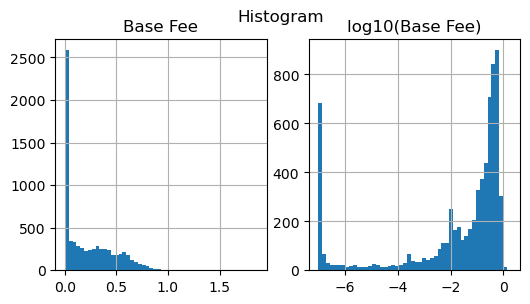

In [8]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
df_basefee['unit_base_fee'].hist(bins=50)
plt.title('Base Fee')
plt.subplot(1,2,2)
np.log10(df_basefee['unit_base_fee']).hist(bins=50)
plt.title('log10(Base Fee)')
plt.suptitle('Histogram')

In [9]:
gas_train_df = gas_models.get_training_data(training_start_date, training_end_date)

In [10]:
gas_train_df.head()

,stat_date,total_gas_used,provecommit_sector_gas_used,precommit_sector_gas_used,provecommit_aggregate_gas_used,precommit_sector_batch_gas_used,publish_storage_deals_gas_used,submit_windowed_post_gas_used,date,day_onboarded_rb_power_pib,...,total_raw_power_eib,total_qa_power_eib,rb_renewal_rate,day_renewed_qa_power_pib,day_renewed_rb_power_pib,fpr,day_onboarded_deal_power,network_qa_rb_ratio,precommitx_sector_gas_used,provecommitx_sector_gas_used
0,2022-12-01T00:00:00Z,47669602126167,6946921288931,5473800854866,4173581349773,1218855229834,13390461427535,11093536613536,2022-12-01,4.900513,...,15.287992,18.637933,0.622071,32.129242,32.129242,0.826182,2.588095,1.219122,6692656084700,11120502638704
1,2022-12-02T00:00:00Z,45607885065483,9307313574487,5489882794848,1976727065402,877822198281,11838746143109,10828102503580,2022-12-02,5.463226,...,15.391210,18.786623,0.671110,32.095942,32.094513,0.784087,2.204414,1.220607,6367704993129,11284040639889
2,2022-12-03T00:00:00Z,44431816043360,11293222469159,8832805859531,13333315382,119246934388,11203538398130,8766646324191,2022-12-03,5.796570,...,15.494154,18.916621,0.688499,34.813684,34.813599,0.742567,1.857804,1.220888,8952052793919,11306555784541
3,2022-12-04T00:00:00Z,41150077997254,11346935334084,9689904658983,2116221197,74609249,10762030982806,7149476871990,2022-12-04,5.967133,...,15.508494,18.957937,0.702883,43.277560,43.273499,0.744504,1.931995,1.222423,9689979268232,11349051555281
4,2022-12-05T00:00:00Z,42849385237355,10859472903098,9986979799607,0,0,10074386059308,6842666672362,2022-12-05,5.757080,...,15.504893,18.974549,0.665862,36.031763,36.031616,0.735682,1.780421,1.223778,9986979799607,10859472903098


In [11]:
# aggregate base-fee to daily
print(len(df_basefee_daily), len(gas_train_df))
train_df = pd.DataFrame()
train_df['daily_base_fee'] = df_basefee_daily['unit_base_fee'].values
train_df['total_gas_used'] = gas_train_df['total_gas_used'].values

291 291


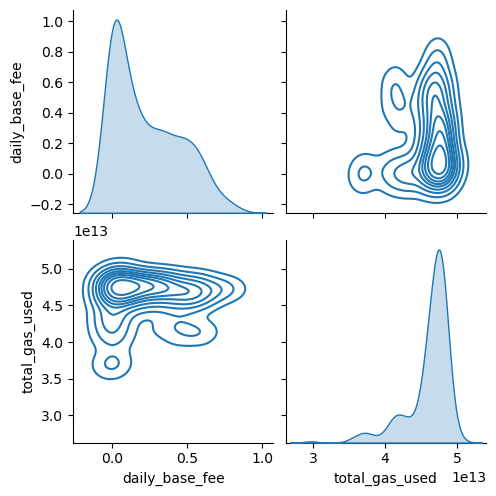

In [12]:
sns.pairplot(train_df, kind='kde')

### Copula Modeling
In this section, we build a copula model for modeling the joint distribution of a) daily_avg_base_fee and b) daily_sum_total_gas_used.
The steps are:
1. Convert the data to [pseudo-observations](https://search.r-project.org/CRAN/refmans/copula/html/pobs.html)
2. Fit a bivariate copula to the pseudo-observations. Although many parametric forms of bivariate copulas exist, we don't specify the form here and let *pyvinecopulib* determine the best family.
3. We can do an eye-test of model fit, by plotting the original data, and simulated data from the copula, in the pseudo-observation space. Here, we see that the model seems to fit the data well.

In [13]:
X = train_df[['daily_base_fee', 'total_gas_used']]
U = pv.to_pseudo_obs(X)

In [14]:
cop = pv.Bicop(data=U)
print(cop)

<pyvinecopulib.Bicop>
TLL, parameters = [30x30 grid]


In [15]:
V = cop.simulate(len(U))

Text(0.5, 1.0, 'Copula Model for DailyBaseFee & TotalGasUsed')

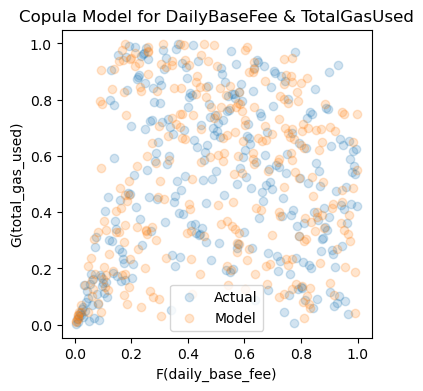

In [16]:
plt.figure(figsize=(4,4))
plt.scatter(U[:,0], U[:,1], alpha=0.2, label='Actual')
plt.scatter(V[:,0], V[:,1], alpha=0.2, label='Model')
plt.xlabel('F(daily_base_fee)')
plt.ylabel('G(total_gas_used)')
plt.legend()
plt.title('Copula Model for DailyBaseFee & TotalGasUsed')

### Generating conditional densities
The copula models the joint density: `H(base_fee, total_gas_used) = C(F(base_fee), G(total_gas_used))`
- `C` is the copula function
- `F` is the CDF of the `base_fee`
- `G` is the CDF of `total_gas_used`
- `H` is the multivariate CDF of `base_fee` and `total_gas_used`
From this copula model, we would like to get samples from the conditional distribution: `p(base_fee | total_gas_used)`

Let us define:
- `U = F(base_fee)`
- `V = G(total_gas_used)`
- `h` is the PDF of the corresponding CDF `H`
- `c` is the corresponding copula density of the copula function `C`

Refer to [copula density](https://en.wikipedia.org/wiki/Copula_(probability_theory)#Mathematical_derivation_of_copula_density_function) for more information about mapping the copula function, `C`, to the copula density, `c`.

Using the relationship of copula density, we can get the desired conditional density as follows:
```
c(u,v) = f(x,y)/(f(x)*f(y))
c(u,v) * f(x) = f(x,y)/f(y)
==>
f(x|y) = c(u,v)*f(x)
==>
X = base_fee
Y = total_gas_used
```

We could extend this to the distribution function as well, to make sampling easier. However, there is a built-in function in `pyvinecopulib` that does this for you.  `hfunc1` and `hfunc2` compute the conditional densities of `P(U2<=u2|U1=u1)` and `P(U1<=u1|U2=u2)`, respectively.  So we can use this directly. Note that `hfunc1` and `hfunc2` operate in the copula space, so we need to apply the inverse CDF of the marginal to get back to the original data space.

In [17]:
total_gasused_daily_density = sm.nonparametric.KDEUnivariate(X['total_gas_used'])
total_gasused_daily_density.fit()
basefee_daily_density = sm.nonparametric.KDEUnivariate(X['daily_base_fee'])
basefee_daily_density.fit()

total_gasused_daily_ECDF = ECDF(X['total_gas_used'])
basefee_ECDF = ECDF(X['daily_base_fee'])

Text(0.5, 1.0, 'P(U<u|GasUsed)')

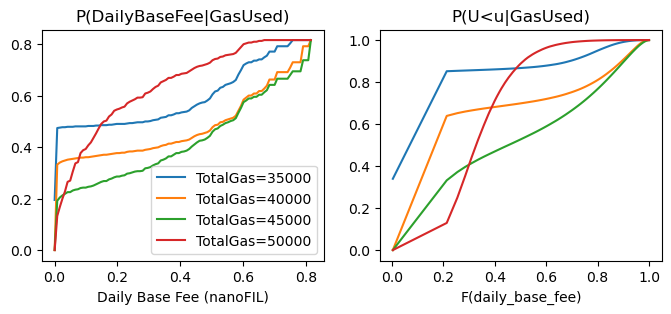

In [23]:
gasused_vec = np.arange(35000, 50000+5000, 5000)*1e9
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))

xx = np.linspace(min(X['daily_base_fee']), max(X['daily_base_fee']), len(basefee_daily_density.cdf))
uu = basefee_daily_density.cdf

for g in gasused_vec:
    base_fee_vec = np.linspace(min(X['daily_base_fee']), max(X['daily_base_fee']), 100)
    u = basefee_ECDF(base_fee_vec)
    v = total_gasused_daily_ECDF(g)
    
    v *= np.ones_like(u)
    U = np.vstack([u,v]).T
    conditional_copula_cdf = cop.hfunc2(U)
    # convert the conditional cdf to the non-pseudoobs space
    F_cdf = np.zeros_like(conditional_copula_cdf)
    for ii, k in enumerate(conditional_copula_cdf):
        best_idx = np.argmin(np.abs(uu-k))
        F_cdf[ii] = xx[best_idx]

    ax[0].plot(base_fee_vec, F_cdf, label='TotalGas=%d' % (g//1e9,))
    ax[1].plot(u, conditional_copula_cdf, label='TotalGas=%d' % (g//1e9,))

ax[0].legend()
ax[0].set_xlabel('Daily Base Fee (nanoFIL)')
ax[0].set_title('P(DailyBaseFee|GasUsed)')

# ax[1].legend()
ax[1].set_xlabel('F(daily_base_fee)')
ax[1].set_title('P(U<u|GasUsed)')

### Sampling from Conditional Densities for Monte-Carlo Simulations
We use the [Inverse Transform Sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling#The_method) method for generating samples from the conditional distributions.

U ~ Unif(0,1)
draw u from U
x = F^{-1}(u)

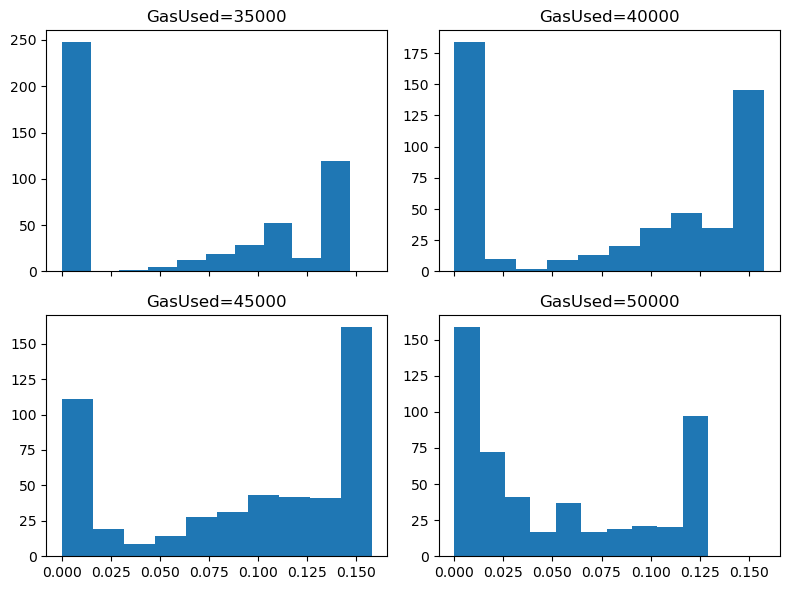

In [37]:
nsamp = 500
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(8,6))
for kk, g in enumerate(gasused_vec):
    base_fee_vec = np.linspace(min(X['daily_base_fee']), max(X['daily_base_fee']), 100)
    u = basefee_ECDF(base_fee_vec)
    v = total_gasused_daily_ECDF(g)
    
    v *= np.ones_like(u)
    U = np.vstack([u,v]).T
    conditional_copula_cdf = cop.hfunc2(U)
    # convert the conditional cdf to the non-pseudoobs space
    F_cdf = np.zeros_like(conditional_copula_cdf)
    for ii, k in enumerate(conditional_copula_cdf):
        best_idx = np.argmin(np.abs(uu-k))
        F_cdf[ii] = xx[best_idx]

    samps_vec = []
    for jj in range(nsamp):
        u = np.random.rand()
        best_idx = np.argmin(np.abs(F_cdf-u))
        samps_vec.append(xx[best_idx])

    ix,iy = np.unravel_index(kk, (2,2))
    ax[ix][iy].hist(samps_vec)
    ax[ix][iy].set_title('GasUsed=%d' % (g//1e9,))

plt.tight_layout()